# Importing The Dataset

In [148]:
import pandas as pd
import numpy as np
original_data = pd.read_csv("data/train.csv")
original_data.shape
pd.set_option('display.max_columns', None)

In [149]:
data = original_data.copy()
original_data.shape

(155711, 13)

In [150]:
data.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        4213
engine              0
transmission        0
ext_col             0
int_col             0
accident         2033
clean_title     17750
target              0
dtype: int64

# Data Cleaning

### Fuel_type columns 

In [151]:
data['fuel_type'].unique()

array(['Gasoline', nan, 'E85 Flex Fuel', 'Hybrid', 'Diesel',
       'Plug-In Hybrid', 'not supported', '–'], dtype=object)

In [152]:
data['fuel_type'].replace('–', "unknown", inplace=True)
data['fuel_type'].replace('not supported', "unknown", inplace=True)
data['fuel_type'].fillna('unknown' , inplace = True)

### Accident Column

In [153]:
data['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [154]:
data.dropna(subset=['accident'], inplace=True)

### Clean_Title columns

In [155]:
data['clean_title'].unique()

array(['Yes', nan], dtype=object)

In [156]:
data['clean_title'].fillna('Unknown', inplace=True);

# Outlier Removal

In [161]:
data.describe()

,id,model_year,milage,target
count,37185.000000,37185.000000,37185.000000,37185.000000
mean,110683.495334,2017.141831,56548.068603,31796.550437
std,45100.343650,3.475371,16177.064008,6584.541995
min,32822.000000,1974.000000,26315.000000,20900.000000
25%,71471.000000,2016.000000,44362.000000,26500.000000
50%,110613.000000,2018.000000,56000.000000,31000.000000
75%,150049.000000,2019.000000,69341.000000,36990.000000
max,188532.000000,2024.000000,88883.000000,44999.000000


In [160]:
lower_percentile = data['milage'].quantile(0.15)
upper_percentile = data['milage'].quantile(0.85)

data = data[(data['milage'] >= lower_percentile) & (data['milage'] <= upper_percentile)]

lower_target_percentile = data['target'].quantile(0.15)
upper_target_percentile = data['target'].quantile(0.85)
data = data[(data['target'] >= lower_target_percentile) & (data['target'] <= upper_target_percentile)]

# Exploratory Data Analysis

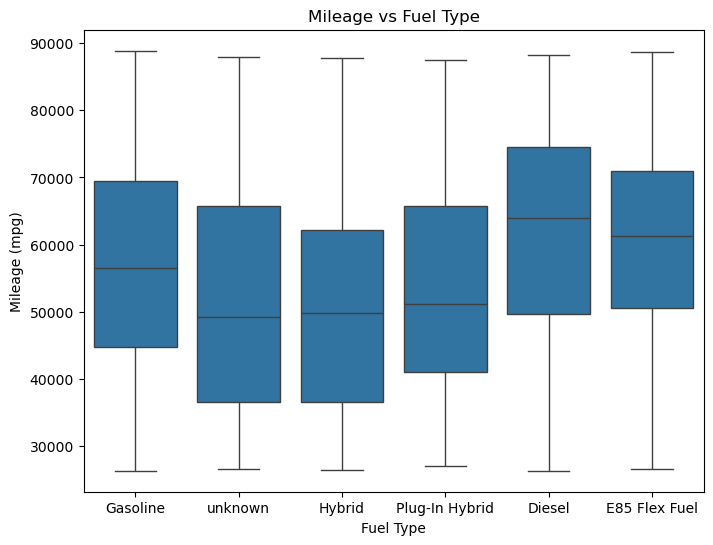

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='fuel_type', y='milage', data=data)
plt.title('Mileage vs Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Mileage (mpg)');

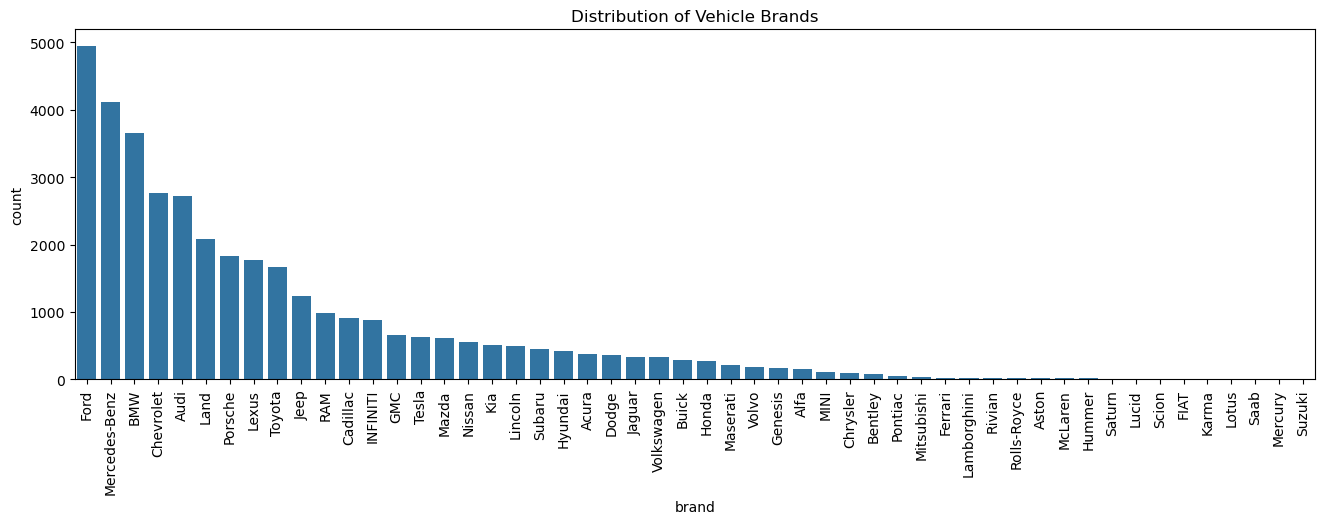

In [163]:
plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
sns.countplot(data=data, x='brand', order=data['brand'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Vehicle Brands');

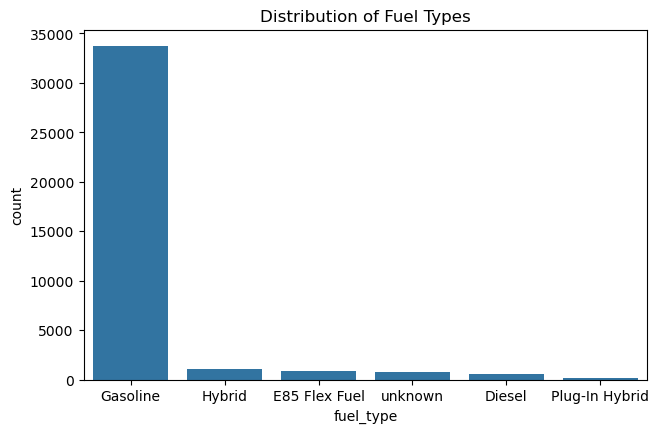

In [164]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 2)
sns.countplot(data=data, x='fuel_type',order=data['fuel_type'].value_counts().index)
plt.title('Distribution of Fuel Types');

# Data Preprocessing and Transformation

In [165]:
data.drop(['id','model'] , axis= 1 ,inplace = True)

### Encoding the categorical columns

In [166]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

columns = ['accident','clean_title' ,'fuel_type', 'ext_col', 'int_col', 'engine',
       'transmission','brand' ]

for col in columns:
    data[col] = encoder.fit_transform(data[col])

### Scaling the numerical Columns

In [167]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
columns_to_scale = [ 'milage']
data[columns_to_scale] = scale.fit_transform(data[columns_to_scale])

In [168]:
data.head()

,brand,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,target
0,8,2014,0.090861,2,801,15,33,12,1,1,27500
3,34,2016,0.434487,2,493,35,241,12,0,1,21400
14,4,2015,0.578331,2,760,22,112,12,1,1,40500
16,48,2020,0.266670,5,865,0,241,12,1,1,32000
20,37,2009,0.698200,2,819,19,281,12,0,1,28000


# Splitting the data for training and testing

In [169]:
X = data.drop('target' , axis = 1)
Y = data['target']

In [170]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Preparing the test dataset

In [171]:
test = pd.read_csv("data/test.csv")
test_data = test.copy()
test_data['fuel_type'].replace('–', "unknown", inplace=True)
test_data['fuel_type'].replace('not supported', "unknown", inplace=True)
test_data['fuel_type'].fillna('unknown' , inplace = True)
test_data['accident'].dropna(inplace = True)
test_data.dropna(subset=['accident'], inplace=True)
test_data.isnull().sum()
test_data.drop(['id','model'] , axis= 1 ,inplace = True)

columns = ['accident','clean_title' ,'fuel_type', 'ext_col', 'int_col', 'engine',
       'transmission','brand' ]
for col in columns:
    test_data[col] = encoder.fit_transform(test_data[col])

columns_to_scale = [ 'milage']
test_data[columns_to_scale] = scale.fit_transform(test_data[columns_to_scale])

# XGBoost Regressor

In [172]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model1 = XGBRegressor(n_estimators=50, learning_rate=0.04, max_depth=5,reg_alpha=1, reg_lambda=1)
model1.fit(X_train, y_train);

y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)


train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_test, y_test_pred)
val_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train MAE: {train_mae}, Train MSE: {train_mse}")
print(f"Validation MAE: {val_mae}, Validation MSE: {val_mse}\n")


kf = KFold(n_splits=5)
mse = cross_val_score(model1, X, Y, cv=kf,scoring='neg_mean_squared_error')
mse = -mse

print("Cross-validation scores:", mse)
print("Average accuracy:", mse.mean())

Train MAE: 4870.608714114698, Train MSE: 33892768.15930475
Validation MAE: 4828.037161892478, Validation MSE: 33763557.61222975

Cross-validation scores: [34414080.13407876 34245272.20902175 34536399.6697657  33789797.2138696
 35130291.08739807]
Average accuracy: 34423168.06282678


# Saving predictions into CSV file for Submission

In [173]:
id = test['id']

In [174]:
y_pred  = model1.predict(test_data).flatten()
y_pred_series = pd.Series(y_pred)
result = pd.concat([id , y_pred_series] , axis = 1)
result.columns = ['id', 'target']
result.to_csv('submissionXG.csv',header= ['id', 'target'], index=False)